In [3]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
from scipy import sparse as sp
from time import time
import scipy.sparse.linalg as spla
from math import sqrt
import simulated_data as simd
import data_strm_subclass as dssb
import streaming_subclass as stsb
import plot_functions as pf
import pickle


In [4]:
def expvar(X, W, xnorm2=None):
    '''
    Calculate the explained variance of X
    Inputs:
        X: n x d array-like
        W: d x k array-like
        xnorm2: optional float, the squared frobenius norm of X. This is often
            calculated in other applications and can thus be provided.
    '''
    
    if xnorm2 is None:
        xnorm2 = la.norm(X, ord='fro')**2
    return la.norm(X.dot(W), ord='fro')**2 / xnorm2

# Loading the Data

In [5]:
# Load Small bag of words data
kos_n, kos_d, kos_nnz, kos_dense, kos_SpX, kos_norm2 = dssb.get_bagX('docword.kos.txt') 
nips_n, nips_d, nips_nnz, nips_dense, nips_SpX, nips_norm2 = dssb.get_bagX('docword.nips.txt')
enr_n, enr_d, enr_nnz, enr_dense, enr_SpX, enr_norm2 = dssb.get_bagX('docword.enron.txt')

In [6]:
# Load the CIFAR dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load the CIFAR data
db = []
for i in range(1, 6):
    db.append(unpickle('data_batch_' + str(i))[b'data'])
CIFAR = np.vstack(db)

# Centralize the CIFAR data
CIFAR_sc = CIFAR - CIFAR.mean(axis=0)
CIFAR_norm2 = la.norm(CIFAR_sc, ord='fro')**2
v_CIFAR = la.eigh(np.cov(CIFAR.T))[1][:,::-1]

In [18]:
CIFAR_evar = expvar(CIFAR_sc, v_CIFAR[:,:k], xnorm2=CIFAR_norm2)

In [7]:
k = 10
# Obtain true ExpVar for Small Bag-of-words data
v_kos = spla.svds((kos_SpX.T.dot(kos_SpX)).astype(float), k=k)[2].T
kos_expvar = la.norm(kos_SpX.dot(v_kos), ord='fro')**2 / kos_norm2

v_nips = spla.svds((nips_SpX.T.dot(nips_SpX)).astype(float), k=k)[2].T
nips_expvar = la.norm(nips_SpX.dot(v_nips), ord='fro')**2 / nips_norm2

#v_enr = spla.svds((enr_SpX.T.dot(enr_SpX)).astype(float), k=k)[2].T
#enr_expvar = la.norm(enr_SpX.dot(v_enr), ord='fro')**2 / enr_norm2

# Small Bag of Words Data

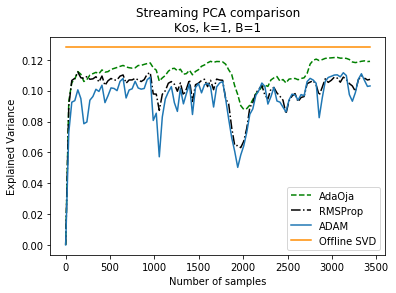

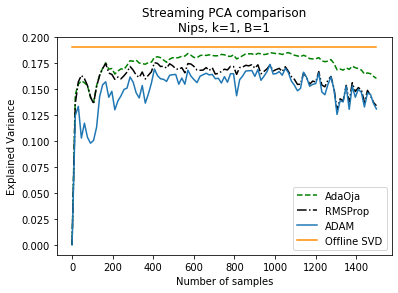

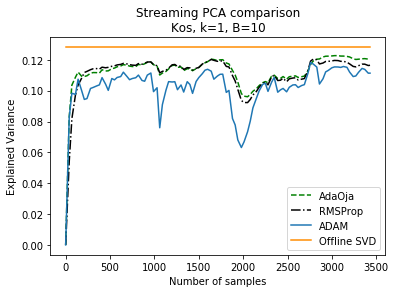

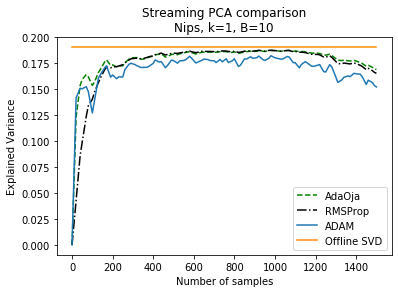

Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)
Number of accuracy readings is greater than the number of samples. Setting num_acc to int(n/B)


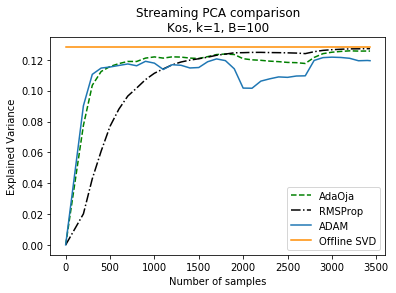

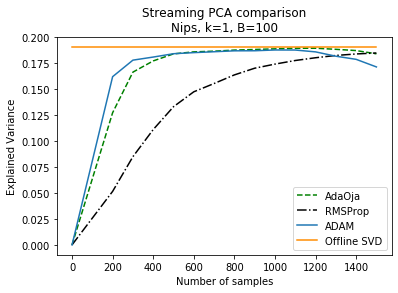

In [17]:
# Plot comparison of AdaOja, RMSProp and ADAM convergence (varying B)
for B in [1, 10, 100]:
    adaoja_kos, rmsp_kos, adam_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], eta=.1, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1)
    adaoja_nips, rmsp_nips, adam_nips = dssb.run_sim_bag('docword.nips.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, X=nips_SpX, xnorm2=nips_norm2, eta=.1, b0_dim=1)
    #adaoja_enr, rmsp_enr, adam_enr = dssb.run_sim_bag('docword.enron.txt', k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, X=enr_SpX, xnorm2=enr_norm2, eta=.1, b0_dim=1)
    pf.plot_mom_comp(adaoja_kos, rmsp_kos, adam_kos, 'Kos', true_evar=kos_expvar)
    pf.plot_mom_comp(adaoja_nips, rmsp_nips, adam_nips, 'Nips', true_evar=nips_expvar)
    #pf.plot_mom_comp(adaoja_enr, rmsp_enr, adam_enr, 'Enron', true_evar=enr_expvar)

# CIFAR

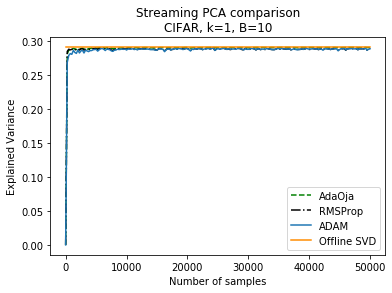

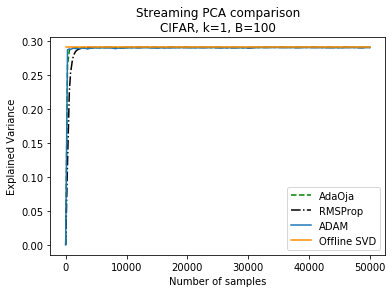

In [6]:
# Plot comparison of AdaOja, HPCA and SPM convergence for B=10, 100; k=1...10
k=1
for B in [10, 100]:
    ada_CIFAR, rmsp_CIFAR, adam_CIFAR = dssb.run_sim_fullX(CIFAR_sc, k, methods=['AdaOja','RMSProp', 'ADAM'], B=B, Sparse=False, xnorm2 = CIFAR_norm2, num_acc=200, bias_correction=False, b0_dim=1, eta=.1)
    CIFAR_evar = expvar(CIFAR_sc, v_CIFAR[:,:k], xnorm2=CIFAR_norm2)
    pf.plot_mom_comp(ada_CIFAR, rmsp_CIFAR, adam_CIFAR, 'CIFAR', true_evar=CIFAR_evar)

# ADAM and RMSProp

## Recommended parameters 

The recommended parameters for RMSProp are $\gamma = 0.9, \eta = 0.001$
The recommended parameters for ADAM are $\beta_1 =0.9, \beta_2 = 0.999, \epsilon = 10^{-8}, \eta=0.001$.
We proceed following the original algorithms using these parameters.
The original algorithms are also designed for the single update step rather than the block update step, so we begin by setting $B=1$.


## Single Value, Vector and Matrix cases
RMSProp and ADAM were originally proposed for the single vector case. Therefore, we can consider three different kinds of update steps for the case $k > 1$. 

1. Single Value
2. Vector Case
3. Matrix Case

In [15]:
def comp_b0_dim(spca0, spca1, spca2, dataname, methodname, true_evar=None):
    '''
    Plotting function to compare the accuracy evolution for the single, 
    vector and matrix versions of the desired streaming pca method.
    '''
    plt.plot(spca0.acc_indices, spca0.accQ, label='Single Case')
    plt.plot(spca1.acc_indices, spca1.accQ, label='Vector Case')
    plt.plot(spca2.acc_indices, spca2.accQ, label='Matrix Case')
    
    if true_evar is not None:
        assert true_evar >= 0 and true_evar <=1, "The true explained variance should be a float > 0"
        plt.plot(spca0.acc_indices, np.ones_like(spca0.acc_indices) * true_evar, label='Offline SVD')

    plt.legend(loc='best')
    plt.title('Comparing Single, Vector and Matrix Case\n Method: ' + methodname + ', data: '+ dataname)
    plt.show()

In [8]:
k = 10
B = 1
rmsp0_kos, adam0_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=0, bias_correction=True)
rmsp1_kos, adam1_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1, bias_correction=True)
rmsp2_kos, adam2_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=2, bias_correction=True)

D:\Ward Research\Code\Proposal Code\streaming_subclass.py:669: RuntimeWarning: overflow encountered in double_scalars
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:669: RuntimeWarning: overflow encountered in true_divide
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:670: RuntimeWarning: invalid value encountered in sqrt
  self.stepvals.append(self.eta/(np.sqrt(self.b0)+self.delta))
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:671: RuntimeWarning: invalid value encountered in sqrt
  self.Q += self.eta / (np.sqrt(self.b0) + self.delta) * self.m0


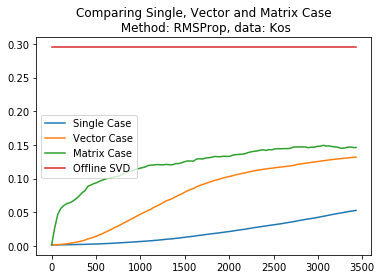

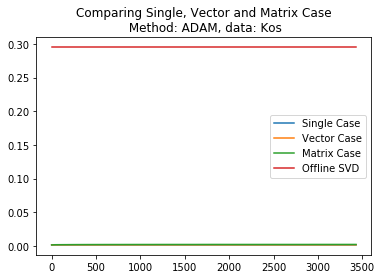

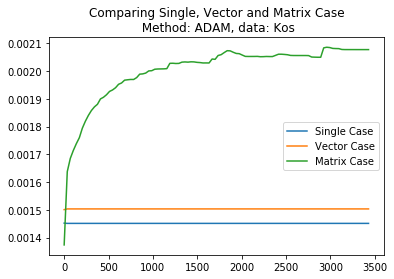

In [21]:
comp_b0_dim(rmsp0_kos, rmsp1_kos, rmsp2_kos, 'Kos', 'RMSProp', true_evar=kos_expvar)
comp_b0_dim(adam0_kos, adam1_kos, adam2_kos, 'Kos', 'ADAM', true_evar=kos_expvar)
comp_b0_dim(adam0_kos, adam1_kos, adam2_kos, 'Kos', 'ADAM')

In [17]:
rmsp0_cif, adam0_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, xnorm2=CIFAR_norm2, b0_dim=0, bias_correction=True, Sparse=False)
rmsp1_cif, adam1_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=1, bias_correction=True, Sparse=False)
rmsp2_cif, adam2_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['RMSProp', 'ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=2, bias_correction=True, Sparse=False)

D:\Ward Research\Code\Proposal Code\streaming_subclass.py:650: RuntimeWarning: overflow encountered in double_scalars
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:650: RuntimeWarning: overflow encountered in true_divide
  self.b0 /= (1 - self.beta_2**self.sample_num)
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:651: RuntimeWarning: invalid value encountered in sqrt
  self.stepvals.append(self.eta/(np.sqrt(self.b0) + self.delta))
D:\Ward Research\Code\Proposal Code\streaming_subclass.py:652: RuntimeWarning: invalid value encountered in sqrt
  self.Q += self.eta / (np.sqrt(self.b0) + self.delta) * self.m0


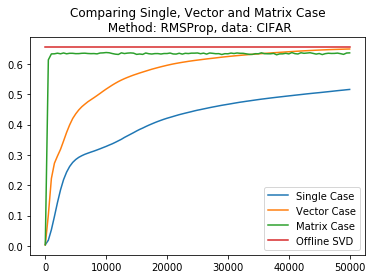

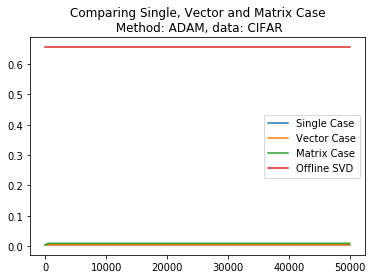

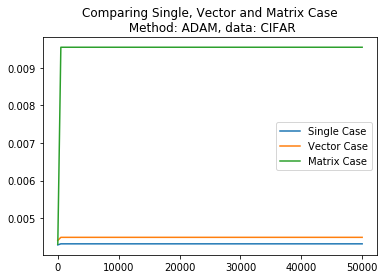

In [20]:
comp_b0_dim(rmsp0_cif, rmsp1_cif, rmsp2_cif, 'CIFAR', 'RMSProp', true_evar=CIFAR_evar)
comp_b0_dim(adam0_cif, adam1_cif, adam2_cif, 'CIFAR', 'ADAM', true_evar=CIFAR_evar)
comp_b0_dim(adam0_cif, adam1_cif, adam2_cif, 'CIFAR', 'ADAM')

From the above, we see that the matrix case obtains the best results for RMSProp for our sparse kos dataset. Though the matrix case converges more quickly for our dense CIFAR data, the vector case actually achieves better final accuracy. 

For ADAM, the matrix case obtains the best results, but the overall results are nowhere near the true solution for either the sparse or the dense data. Why?
One part of ADAM that might be unecessary is *bias correction* which essentially seeks to correct for the fact that $m_0$ and $b_0$ are initialized as vectors of zeros. 
However, this effect may already be mitigated by the normalization step in Oja's method.

Let us modify ADAM and remove the bias correction steps to see if this improves our results:

In [23]:
adam0_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=0, bias_correction=False)
adam1_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=1, bias_correction=False)
adam2_kos = dssb.run_sim_bag('docword.kos.txt', k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, X=kos_SpX, xnorm2=kos_norm2, b0_dim=2, bias_correction=False)

In [ ]:
adam0_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8,  B=B, xnorm2=CIFAR_norm2, b0_dim=0, bias_correction=False, Sparse=False)
adam1_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=1, bias_correction=False, Sparse=False)
adam2_cif = dssb.run_sim_fullX(CIFAR_sc, k, methods=['ADAM'], eta=.001, gamma=.9, beta_1 = 0.9, beta_2=0.999, delta=1e-8, B=B, xnorm2=CIFAR_norm2, b0_dim=2, bias_correction=False, Sparse=False)

In [ ]:
comp_b0_dim(adam0_kos, adam1_kos, adam2_kos, 'kos', 'ADAM', true_evar=kos_expvar)
comp_b0_dim(adam0_cif, adam1_cif, adam2_cif, 'CIFAR', 'ADAM', true_evar=CIFAR_evar)

## The effect of block size, B